In [1]:
%matplotlib inline

import os
import sys
import math
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import invisible_cities.reco.dst_functions as dstf

from   invisible_cities.database               import load_db
from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.io.dst_io              import load_dst

import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d

In [3]:
## style
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
blue = tableau20[0]
green = tableau20[4]
red = tableau20[6]
pink = tableau20[7]
purple = tableau20[8]
light_purple = tableau20[9]
brown = tableau20[10]
grey = tableau20[15]

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 12, 8

In [4]:
## functions to fit
def twogauss(x, amp0, mu0, sigma0, amp, mu, sigma):
    return  amp0/(2*np.pi)**.5/sigma0 * np.exp(-0.5*(x-mu0)**2./sigma0**2.) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def threegauss(x, amp0, mu0, sigma0, amp1, mu1, sigma1, amp, mu, sigma):
    return  amp0/(2*np.pi)**.5/sigma0 * np.exp(-0.5*(x-mu0)**2./sigma0**2.) + amp1/(2*np.pi)**.5/sigma1 * np.exp(-0.5*(x-mu1)**2./sigma1**2.) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def gauss(x, amp, mu, sigma):
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def exp(x, a0, tau):
    return a0 * np.exp(x/tau) 

def expgauss(x, a0, tau, amp, mu, sigma):
    return a0 * np.exp(x/tau) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)



In [82]:
import textwrap
from invisible_cities.evm.ic_containers   import Measurement
from invisible_cities.icaro.hst_functions import measurement_string

def gtext(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = %.3f +/- %.3f mm
        $\sigma$ = %.3f +/- %.3f mm
        FWHM res. = %.3f mm
        """%(values[0] , errors[0],
             values[1] , errors[1], 2.35*values[1]))

def gtext_angle(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = %.3f +/- %.3f degrees
        $\sigma$ = %.3f +/- %.3f degrees
        FWHM res. = %.3f degrees
        """%(values[0] , errors[0],
             values[1] , errors[1], 2.35*values[1]))

In [7]:
true_x1 = true_x2 = true_y1 = true_y2 = true_z1 = true_z2 = []
reco_x1 = reco_x2 = reco_y1 = reco_y2 = reco_z1 = reco_z2 = []
events = []
#reco_x1_int = reco_x2_int = reco_y1_int = reco_y2_int = reco_z1_int = reco_z2_int = []
#reco_x1_ext = reco_x2_ext = reco_y1_ext = reco_y2_ext = reco_z1_ext = reco_z2_ext = []

filename = '/Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_{0}_{1}_0.npz'
#filenames = ['full_ring_depth3cm_pitch4mm_phot_reco_{0}_{1}_0.npz', 
#             'full_ring_depth3cm_pitch4mm_phot_reco_int_{0}_{1}_0.npz', 
#             'full_ring_depth3cm_pitch4mm_phot_reco_ext_{0}_{1}_0.npz']

bunch = 5
for f in range(0, 600, bunch):
    filename = filename.format(f, bunch)
    try:
        d = np.load(filename)
    except:
        print('File {} not found'.format(filename))
        continue 
            
    #print('Loading {}'.format(filename))
    true_x1 = np.concatenate((true_x1, d['a_true_x1']))
    true_y1 = np.concatenate((true_y1, d['a_true_y1']))
    true_z1 = np.concatenate((true_z1, d['a_true_z1']))   
    true_x2 = np.concatenate((true_x2, d['a_true_x2']))
    true_y2 = np.concatenate((true_y2, d['a_true_y2']))
    true_z2 = np.concatenate((true_z2, d['a_true_z2']))
        
    reco_x1 = np.concatenate((reco_x1, d['a_reco_x1']))
    reco_y1 = np.concatenate((reco_y1, d['a_reco_y1']))  
    reco_z1 = np.concatenate((reco_z1, d['a_reco_z1']))   
    reco_x2 = np.concatenate((reco_x2, d['a_reco_x2']))
    reco_y2 = np.concatenate((reco_y2, d['a_reco_y2']))  
    reco_z2 = np.concatenate((reco_z2, d['a_reco_z2']))
            
    events = np.concatenate((events, d['a_events']))
        
true_x1 = np.array(true_x1)
true_x2 = np.array(true_x2)
true_y1 = np.array(true_y1)
true_y2 = np.array(true_y2)
true_z1 = np.array(true_z1)
true_z2 = np.array(true_z2)


reco_x1 = np.array(reco_x1)
reco_x2 = np.array(reco_x2)
reco_y1 = np.array(reco_y1)
reco_y2 = np.array(reco_y2)
reco_z1 = np.array(reco_z1)
reco_z2 = np.array(reco_z2)

events = np.array(events)

File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_0_5_0.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_0_5_0.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_0_5_0.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_0_5_0.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_0_5_0.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_0_5_0.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_0_5_0.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_0_5_0.npz not found
File /Users/paola/PETALO/analysis/observables/photoelect

In [7]:
len(true_x1)

772011

In [8]:
true_x1_thr2 = true_x2_thr2 = true_y1_thr2 = true_y2_thr2 = true_z1_thr2 = true_z2_thr2 = []
reco_x1_thr2 = reco_x2_thr2 = reco_y1_thr2 = reco_y2_thr2 = reco_z1_thr2 = reco_z2_thr2 = []
events_thr2 = []

file_base = '/Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch4mm_phot_reco_{0}_{1}_2.npz'

bunch = 5
for f in range(0, 600, bunch):
    filename = file_base.format(f, bunch)
    try:
        d = np.load(filename)
    except:
        print('File {} not found'.format(filename))
        continue 
            
    true_x1_thr2 = np.concatenate((true_x1_thr2, d['a_true_x1']))
    true_y1_thr2 = np.concatenate((true_y1_thr2, d['a_true_y1']))
    true_z1_thr2 = np.concatenate((true_z1_thr2, d['a_true_z1']))   
    true_x2_thr2 = np.concatenate((true_x2_thr2, d['a_true_x2']))
    true_y2_thr2 = np.concatenate((true_y2_thr2, d['a_true_y2']))
    true_z2_thr2 = np.concatenate((true_z2_thr2, d['a_true_z2']))
            
    reco_x1_thr2 = np.concatenate((reco_x1_thr2, d['a_reco_x1']))
    reco_y1_thr2 = np.concatenate((reco_y1_thr2, d['a_reco_y1']))
    reco_z1_thr2 = np.concatenate((reco_z1_thr2, d['a_reco_z1']))   
    reco_x2_thr2 = np.concatenate((reco_x2_thr2, d['a_reco_x2']))
    reco_y2_thr2 = np.concatenate((reco_y2_thr2, d['a_reco_y2']))
    reco_z2_thr2 = np.concatenate((reco_z2_thr2, d['a_reco_z2']))
    
    events_thr2 = np.concatenate((events_thr2, d['a_events']))
    
true_x1_thr2 = np.array(true_x1_thr2)
true_x2_thr2 = np.array(true_x2_thr2)
true_y1_thr2 = np.array(true_y1_thr2)
true_y2_thr2 = np.array(true_y2_thr2)
true_z1_thr2 = np.array(true_z1_thr2)
true_z2_thr2 = np.array(true_z2_thr2)


reco_x1_thr2 = np.array(reco_x1_thr2)
reco_x2_thr2 = np.array(reco_x2_thr2)
reco_y1_thr2 = np.array(reco_y1_thr2)
reco_y2_thr2 = np.array(reco_y2_thr2)
reco_z1_thr2 = np.array(reco_z1_thr2)
reco_z2_thr2 = np.array(reco_z2_thr2)

events_thr2 = np.array(events_thr2)

In [9]:
true_x1_thr2_6mm = true_x2_thr2_6mm = true_y1_thr2_6mm = true_y2_thr2_6mm = true_z1_thr2_6mm = true_z2_thr2_6mm = []
reco_x1_thr2_6mm = reco_x2_thr2_6mm = reco_y1_thr2_6mm = reco_y2_thr2_6mm = reco_z1_thr2_6mm = reco_z2_thr2_6mm = []
events_thr2_6mm = []

file_base = '/Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_{0}_{1}_2.npz'

bunch = 5
for f in range(0, 600, bunch):
    filename = file_base.format(f, bunch)
    try:
        d = np.load(filename)
    except:
        print('File {} not found'.format(filename))
        continue 
          
    #print('Loading {}'.format(filename))
    true_x1_thr2_6mm = np.concatenate((true_x1_thr2_6mm, d['a_true_x1']))
    true_y1_thr2_6mm = np.concatenate((true_y1_thr2_6mm, d['a_true_y1']))
    true_z1_thr2_6mm = np.concatenate((true_z1_thr2_6mm, d['a_true_z1']))   
    true_x2_thr2_6mm = np.concatenate((true_x2_thr2_6mm, d['a_true_x2']))
    true_y2_thr2_6mm = np.concatenate((true_y2_thr2_6mm, d['a_true_y2']))
    true_z2_thr2_6mm = np.concatenate((true_z2_thr2_6mm, d['a_true_z2']))
            
    reco_x1_thr2_6mm = np.concatenate((reco_x1_thr2_6mm, d['a_reco_x1']))
    reco_y1_thr2_6mm = np.concatenate((reco_y1_thr2_6mm, d['a_reco_y1']))
    reco_z1_thr2_6mm = np.concatenate((reco_z1_thr2_6mm, d['a_reco_z1']))   
    reco_x2_thr2_6mm = np.concatenate((reco_x2_thr2_6mm, d['a_reco_x2']))
    reco_y2_thr2_6mm = np.concatenate((reco_y2_thr2_6mm, d['a_reco_y2']))
    reco_z2_thr2_6mm = np.concatenate((reco_z2_thr2_6mm, d['a_reco_z2']))
    
    events_thr2_6mm = np.concatenate((events_thr2_6mm, d['a_events']))
    
    
true_x1_thr2_6mm = np.array(true_x1_thr2_6mm)
true_x2_thr2_6mm = np.array(true_x2_thr2_6mm)
true_y1_thr2_6mm = np.array(true_y1_thr2_6mm)
true_y2_thr2_6mm = np.array(true_y2_thr2_6mm)
true_z1_thr2_6mm = np.array(true_z1_thr2_6mm)
true_z2_thr2_6mm = np.array(true_z2_thr2_6mm)


reco_x1_thr2_6mm = np.array(reco_x1_thr2_6mm)
reco_x2_thr2_6mm = np.array(reco_x2_thr2_6mm)
reco_y1_thr2_6mm = np.array(reco_y1_thr2_6mm)
reco_y2_thr2_6mm = np.array(reco_y2_thr2_6mm)
reco_z1_thr2_6mm = np.array(reco_z1_thr2_6mm)
reco_z2_thr2_6mm = np.array(reco_z2_thr2_6mm)

events_thr2_6mm = np.array(events_thr2_6mm)

In [11]:
true_x1_thr3_6mm_10rows = true_x2_thr3_6mm_10rows = true_y1_thr3_6mm_10rows = true_y2_thr3_6mm_10rows = true_z1_thr3_6mm_10rows = true_z2_thr3_6mm_10rows = []
reco_x1_thr3_6mm_10rows = reco_x2_thr3_6mm_10rows = reco_y1_thr3_6mm_10rows = reco_y2_thr3_6mm_10rows = reco_z1_thr3_6mm_10rows = reco_z2_thr3_6mm_10rows = []
events_thr3_6mm_10rows = []

file_base = '/Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_10rows_phot_reco_{0}_{1}_3.npz'

bunch = 5
for f in range(0, 400, bunch):
    filename = file_base.format(f, bunch)
    try:
        d = np.load(filename)
    except:
        print('File {} not found'.format(filename))
        continue 
          
    #print('Loading {}'.format(filename))
    true_x1_thr3_6mm_10rows = np.concatenate((true_x1_thr3_6mm_10rows, d['a_true_x1']))
    true_y1_thr3_6mm_10rows = np.concatenate((true_y1_thr3_6mm_10rows, d['a_true_y1']))
    true_z1_thr3_6mm_10rows = np.concatenate((true_z1_thr3_6mm_10rows, d['a_true_z1']))   
    true_x2_thr3_6mm_10rows = np.concatenate((true_x2_thr3_6mm_10rows, d['a_true_x2']))
    true_y2_thr3_6mm_10rows = np.concatenate((true_y2_thr3_6mm_10rows, d['a_true_y2']))
    true_z2_thr3_6mm_10rows = np.concatenate((true_z2_thr3_6mm_10rows, d['a_true_z2']))
            
    reco_x1_thr3_6mm_10rows = np.concatenate((reco_x1_thr3_6mm_10rows, d['a_reco_x1']))
    reco_y1_thr3_6mm_10rows = np.concatenate((reco_y1_thr3_6mm_10rows, d['a_reco_y1']))
    reco_z1_thr3_6mm_10rows = np.concatenate((reco_z1_thr3_6mm_10rows, d['a_reco_z1']))   
    reco_x2_thr3_6mm_10rows = np.concatenate((reco_x2_thr3_6mm_10rows, d['a_reco_x2']))
    reco_y2_thr3_6mm_10rows = np.concatenate((reco_y2_thr3_6mm_10rows, d['a_reco_y2']))
    reco_z2_thr3_6mm_10rows = np.concatenate((reco_z2_thr3_6mm_10rows, d['a_reco_z2']))
    
    events_thr3_6mm_10rows = np.concatenate((events_thr3_6mm_10rows, d['a_events']))
    
    
true_x1_thr3_6mm_10rows = np.array(true_x1_thr3_6mm_10rows)
true_x2_thr3_6mm_10rows = np.array(true_x2_thr3_6mm_10rows)
true_y1_thr3_6mm_10rows = np.array(true_y1_thr3_6mm_10rows)
true_y2_thr3_6mm_10rows = np.array(true_y2_thr3_6mm_10rows)
true_z1_thr3_6mm_10rows = np.array(true_z1_thr3_6mm_10rows)
true_z2_thr3_6mm_10rows = np.array(true_z2_thr3_6mm_10rows)


reco_x1_thr3_6mm_10rows = np.array(reco_x1_thr3_6mm_10rows)
reco_x2_thr3_6mm_10rows = np.array(reco_x2_thr3_6mm_10rows)
reco_y1_thr3_6mm_10rows = np.array(reco_y1_thr3_6mm_10rows)
reco_y2_thr3_6mm_10rows = np.array(reco_y2_thr3_6mm_10rows)
reco_z1_thr3_6mm_10rows = np.array(reco_z1_thr3_6mm_10rows)
reco_z2_thr3_6mm_10rows = np.array(reco_z2_thr3_6mm_10rows)

events_thr3_6mm_10rows = np.array(events_thr3_6mm_10rows)

File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_10rows_phot_reco_400_5_3.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_10rows_phot_reco_405_5_3.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_10rows_phot_reco_410_5_3.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_10rows_phot_reco_415_5_3.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_10rows_phot_reco_420_5_3.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_10rows_phot_reco_425_5_3.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_10rows_phot_reco_430_5_3.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_10rows_phot_reco_435_5_

In [12]:
true_x1_thr3 = true_x2_thr3 = true_y1_thr3 = true_y2_thr3 = true_z1_thr3 = true_z2_thr3 = []
reco_x1_thr3 = reco_x2_thr3 = reco_y1_thr3 = reco_y2_thr3 = reco_z1_thr3 = reco_z2_thr3 = []
events_thr3 = []

file_base = '/Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch4mm_phot_reco_{0}_{1}_3.npz'

bunch = 5
for f in range(0, 600, bunch):
    filename = file_base.format(f, bunch)
    try:
        d = np.load(filename)
    except:
        print('File {} not found'.format(filename))
        continue 
            
    true_x1_thr3 = np.concatenate((true_x1_thr3, d['a_true_x1']))
    true_y1_thr3 = np.concatenate((true_y1_thr3, d['a_true_y1']))
    true_z1_thr3 = np.concatenate((true_z1_thr3, d['a_true_z1']))   
    true_x2_thr3 = np.concatenate((true_x2_thr3, d['a_true_x2']))
    true_y2_thr3 = np.concatenate((true_y2_thr3, d['a_true_y2']))
    true_z2_thr3 = np.concatenate((true_z2_thr3, d['a_true_z2']))
            
    reco_x1_thr3 = np.concatenate((reco_x1_thr3, d['a_reco_x1']))
    reco_y1_thr3 = np.concatenate((reco_y1_thr3, d['a_reco_y1']))
    reco_z1_thr3 = np.concatenate((reco_z1_thr3, d['a_reco_z1']))   
    reco_x2_thr3 = np.concatenate((reco_x2_thr3, d['a_reco_x2']))
    reco_y2_thr3 = np.concatenate((reco_y2_thr3, d['a_reco_y2']))
    reco_z2_thr3 = np.concatenate((reco_z2_thr3, d['a_reco_z2']))
    
    events_thr3 = np.concatenate((events_thr3, d['a_events']))
    
true_x1_thr3 = np.array(true_x1_thr3)
true_x2_thr3 = np.array(true_x2_thr3)
true_y1_thr3 = np.array(true_y1_thr3)
true_y2_thr3 = np.array(true_y2_thr3)
true_z1_thr3 = np.array(true_z1_thr3)
true_z2_thr3 = np.array(true_z2_thr3)


reco_x1_thr3 = np.array(reco_x1_thr3)
reco_x2_thr3 = np.array(reco_x2_thr3)
reco_y1_thr3 = np.array(reco_y1_thr3)
reco_y2_thr3 = np.array(reco_y2_thr3)
reco_z1_thr3 = np.array(reco_z1_thr3)
reco_z2_thr3 = np.array(reco_z2_thr3)

events_thr3 = np.array(events_thr3)


In [13]:
true_x1_thr3_6mm = true_x2_thr3_6mm = true_y1_thr3_6mm = true_y2_thr3_6mm = true_z1_thr3_6mm = true_z2_thr3_6mm = []
reco_x1_thr3_6mm = reco_x2_thr3_6mm = reco_y1_thr3_6mm = reco_y2_thr3_6mm = reco_z1_thr3_6mm = reco_z2_thr3_6mm = []
events_thr3_6mm = []

file_base = '/Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_{0}_{1}_3.npz'

bunch = 5
for f in range(0, 600, bunch):
    filename = file_base.format(f, bunch)
    try:
        d = np.load(filename)
    except:
        print('File {} not found'.format(filename))
        continue 
            
    true_x1_thr3_6mm = np.concatenate((true_x1_thr3_6mm, d['a_true_x1']))
    true_y1_thr3_6mm = np.concatenate((true_y1_thr3_6mm, d['a_true_y1']))
    true_z1_thr3_6mm = np.concatenate((true_z1_thr3_6mm, d['a_true_z1']))   
    true_x2_thr3_6mm = np.concatenate((true_x2_thr3_6mm, d['a_true_x2']))
    true_y2_thr3_6mm = np.concatenate((true_y2_thr3_6mm, d['a_true_y2']))
    true_z2_thr3_6mm = np.concatenate((true_z2_thr3_6mm, d['a_true_z2']))
            
    reco_x1_thr3_6mm = np.concatenate((reco_x1_thr3_6mm, d['a_reco_x1']))
    reco_y1_thr3_6mm = np.concatenate((reco_y1_thr3_6mm, d['a_reco_y1']))
    reco_z1_thr3_6mm = np.concatenate((reco_z1_thr3_6mm, d['a_reco_z1']))   
    reco_x2_thr3_6mm = np.concatenate((reco_x2_thr3_6mm, d['a_reco_x2']))
    reco_y2_thr3_6mm = np.concatenate((reco_y2_thr3_6mm, d['a_reco_y2']))
    reco_z2_thr3_6mm = np.concatenate((reco_z2_thr3_6mm, d['a_reco_z2']))
    
    events_thr3_6mm = np.concatenate((events_thr3_6mm, d['a_events']))
    
true_x1_thr3_6mm = np.array(true_x1_thr3_6mm)
true_x2_thr3_6mm = np.array(true_x2_thr3_6mm)
true_y1_thr3_6mm = np.array(true_y1_thr3_6mm)
true_y2_thr3_6mm = np.array(true_y2_thr3_6mm)
true_z1_thr3_6mm = np.array(true_z1_thr3_6mm)
true_z2_thr3_6mm = np.array(true_z2_thr3_6mm)


reco_x1_thr3_6mm = np.array(reco_x1_thr3_6mm)
reco_x2_thr3_6mm = np.array(reco_x2_thr3_6mm)
reco_y1_thr3_6mm = np.array(reco_y1_thr3_6mm)
reco_y2_thr3_6mm = np.array(reco_y2_thr3_6mm)
reco_z1_thr3_6mm = np.array(reco_z1_thr3_6mm)
reco_z2_thr3_6mm = np.array(reco_z2_thr3_6mm)

events_thr3_6mm = np.array(events_thr3_6mm)

### Using both SiPMs, comparing thresholds and different pitches

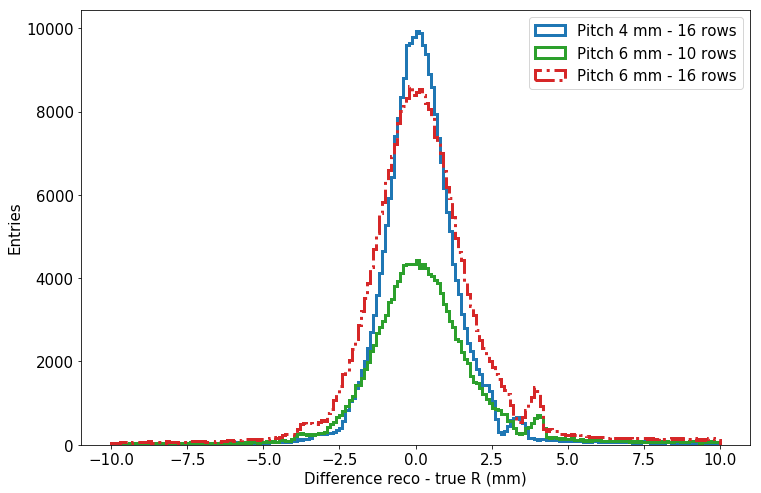

In [48]:
colors = [blue, green, red, purple, brown]
linestyle = ['-', '-.', ':','-','--']

valid1 = reco_x1_thr3 < 1.e9
valid2 = reco_x2_thr3 < 1.e9

rad_true1_thr3 = np.sqrt(true_x1_thr3 * true_x1_thr3 + true_y1_thr3 * true_y1_thr3) 
rad_reco1_thr3 = np.sqrt(reco_x1_thr3 * reco_x1_thr3 + reco_y1_thr3 * reco_y1_thr3)
rad_true2_thr3 = np.sqrt(true_x2_thr3 * true_x2_thr3 + true_y2_thr3 * true_y2_thr3) 
rad_reco2_thr3 = np.sqrt(reco_x2_thr3 * reco_x2_thr3 + reco_y2_thr3 * reco_y2_thr3)

diff_rad1_thr3 = rad_reco1_thr3[valid1] - rad_true1_thr3[valid1]
diff_rad2_thr3 = rad_reco2_thr3[valid2] - rad_true2_thr3[valid2]
diff_rad_thr3 = np.concatenate((diff_rad1_thr3, diff_rad2_thr3))

### 6 mm - 10 rows
valid1 = reco_x1_thr3_6mm_10rows < 1.e9
valid2 = reco_x2_thr3_6mm_10rows < 1.e9

rad_true1_thr3_6mm_10rows = np.sqrt(true_x1_thr3_6mm_10rows * true_x1_thr3_6mm_10rows + true_y1_thr3_6mm_10rows * true_y1_thr3_6mm_10rows) 
rad_reco1_thr3_6mm_10rows = np.sqrt(reco_x1_thr3_6mm_10rows * reco_x1_thr3_6mm_10rows + reco_y1_thr3_6mm_10rows * reco_y1_thr3_6mm_10rows)
rad_true2_thr3_6mm_10rows = np.sqrt(true_x2_thr3_6mm_10rows * true_x2_thr3_6mm_10rows + true_y2_thr3_6mm_10rows * true_y2_thr3_6mm_10rows) 
rad_reco2_thr3_6mm_10rows = np.sqrt(reco_x2_thr3_6mm_10rows * reco_x2_thr3_6mm_10rows + reco_y2_thr3_6mm_10rows * reco_y2_thr3_6mm_10rows)

diff_rad1_thr3_6mm_10rows = rad_reco1_thr3_6mm_10rows[valid1] - rad_true1_thr3_6mm_10rows[valid1]
diff_rad2_thr3_6mm_10rows = rad_reco2_thr3_6mm_10rows[valid2] - rad_true2_thr3_6mm_10rows[valid2]
diff_rad_thr3_6mm_10rows = np.concatenate((diff_rad1_thr3_6mm_10rows, diff_rad2_thr3_6mm_10rows))

### 6 mm
valid1 = reco_x1_thr3_6mm < 1.e9
valid2 = reco_x2_thr3_6mm < 1.e9

rad_true1_thr3_6mm = np.sqrt(true_x1_thr3_6mm * true_x1_thr3_6mm + true_y1_thr3_6mm * true_y1_thr3_6mm) 
rad_reco1_thr3_6mm = np.sqrt(reco_x1_thr3_6mm * reco_x1_thr3_6mm + reco_y1_thr3_6mm * reco_y1_thr3_6mm)
rad_true2_thr3_6mm = np.sqrt(true_x2_thr3_6mm * true_x2_thr3_6mm + true_y2_thr3_6mm * true_y2_thr3_6mm) 
rad_reco2_thr3_6mm = np.sqrt(reco_x2_thr3_6mm * reco_x2_thr3_6mm + reco_y2_thr3_6mm * reco_y2_thr3_6mm)

diff_rad1_thr3_6mm = rad_reco1_thr3_6mm[valid1] - rad_true1_thr3_6mm[valid1]
diff_rad2_thr3_6mm = rad_reco2_thr3_6mm[valid2] - rad_true2_thr3_6mm[valid2]
diff_rad_thr3_6mm = np.concatenate((diff_rad1_thr3_6mm, diff_rad2_thr3_6mm))


plot_range = (-10, 10.)
bins = 200

h0 = plt.hist(diff_rad_thr3, bins=bins, color=colors[0], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Pitch 4 mm - 16 rows', linewidth=3.0, linestyle=linestyle[0])
h2 = plt.hist(diff_rad_thr3_6mm_10rows, bins=bins, color=colors[1], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Pitch 6 mm - 10 rows', linewidth=3.0, linestyle=linestyle[0])
h3 = plt.hist(diff_rad_thr3_6mm, bins=bins, color=colors[2], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Pitch 6 mm - 16 rows', linewidth=3.0, linestyle=linestyle[1])
plt.xlabel('Difference reco - true R (mm)')
plt.ylabel('Entries')
plt.legend(loc=1)

#### 4 mm pitch

[  2.38512738e+04   8.60994292e-02   9.92298828e-01]
[  1.46871470e+02   7.05567312e-03   7.05567280e-03]
Mean = 0.08609942922355923 mm
FWHM = 2.331902245393708 mm


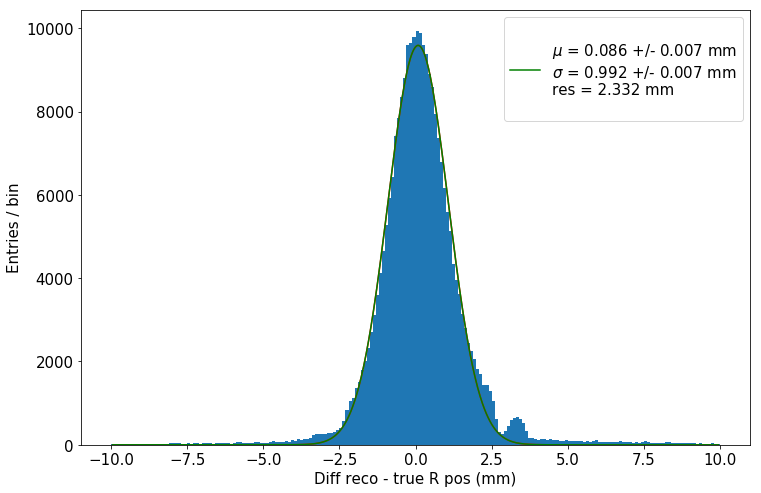

In [63]:
y, x, _ = hist(diff_rad_thr3, bins=bins, range=plot_range, new_figure=False)
plt.xlabel('Diff reco - true R pos (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-10, 10))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))
legend = gtext(f.values[1:],f.errors[1:])
lab2 = '4-mm pitch'

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)

#### 6 mm pitch

[  2.83343317e+04   7.27239460e-02   1.35925438e+00]
[  2.05384786e+02   1.13769747e-02   1.13769751e-02]
Mean = 0.07272394603996449 mm
FWHM = 3.1942477982934925 mm


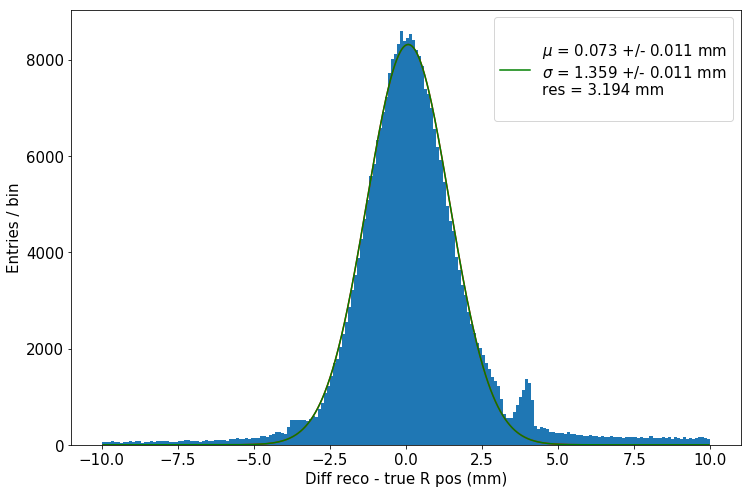

In [64]:
y, x, _ = hist(diff_rad_thr3_6mm, bins=bins, range=plot_range, new_figure=False)
plt.xlabel('Diff reco - true R pos (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-10, 10))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))
legend = gtext(f.values[1:],f.errors[1:])

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)

#### 6 mm - 10 rows only

[  1.46305057e+04   7.70793104e-02   1.36088770e+00]
[  1.10359696e+02   1.18534347e-02   1.18534351e-02]
Mean = 0.07707931041033639 mm
FWHM = 3.1980860841753875 mm


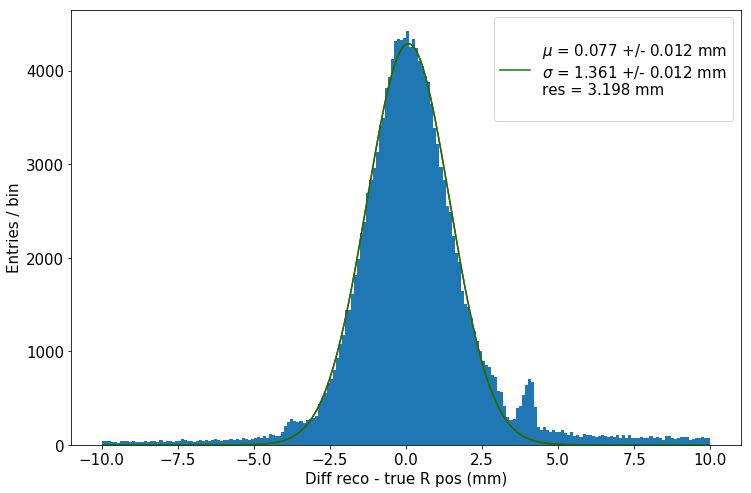

In [65]:
y, x, _ = hist(diff_rad_thr3_6mm_10rows, bins=bins, range=plot_range, new_figure=False)
plt.xlabel('Diff reco - true R pos (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-10, 10))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))
legend = gtext(f.values[1:],f.errors[1:])

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)

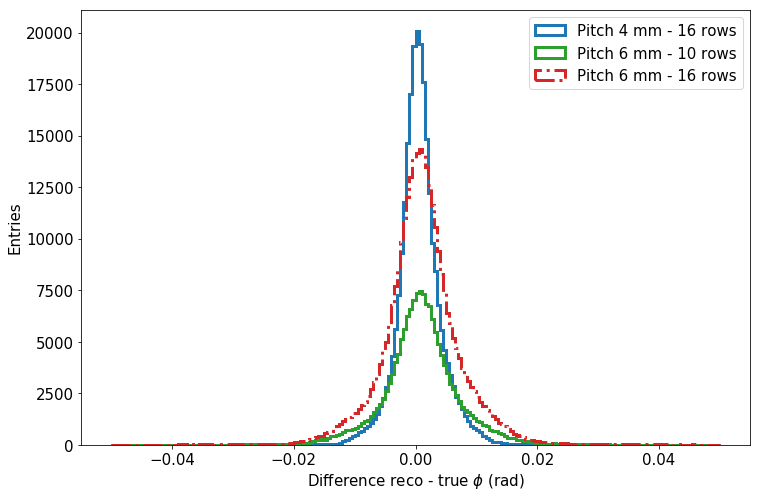

In [70]:
### Threshold 3 pes, pitch 4 mm
valid1 = reco_x1_thr3 < 1.e9
valid2 = reco_x2_thr3 < 1.e9
phi_true1_thr3 = np.arctan2(true_y1_thr3, true_x1_thr3) 
phi_reco1_thr3 = np.arctan2(reco_y1_thr3, reco_x1_thr3) 
phi_true2_thr3 = np.arctan2(true_y2_thr3, true_x2_thr3) 
phi_reco2_thr3 = np.arctan2(reco_y2_thr3, reco_x2_thr3) 

diff_phi1_thr3 = phi_reco1_thr3[valid1] - phi_true1_thr3[valid1]
diff_phi2_thr3 = phi_reco2_thr3[valid2] - phi_true2_thr3[valid2]
diff_phi_thr3 = np.concatenate((diff_phi1_thr3, diff_phi2_thr3))

### Threshold 3 pes, pitch 6 mm

valid1 = reco_x1_thr3_6mm < 1.e9
valid2 = reco_x2_thr3_6mm  < 1.e9
phi_true1_thr3_6mm = np.arctan2(true_y1_thr3_6mm, true_x1_thr3_6mm) 
phi_reco1_thr3_6mm = np.arctan2(reco_y1_thr3_6mm, reco_x1_thr3_6mm) 
phi_true2_thr3_6mm = np.arctan2(true_y2_thr3_6mm, true_x2_thr3_6mm) 
phi_reco2_thr3_6mm = np.arctan2(reco_y2_thr3_6mm, reco_x2_thr3_6mm) 

diff_phi1_thr3_6mm = phi_reco1_thr3_6mm[valid1] - phi_true1_thr3_6mm[valid1]
diff_phi2_thr3_6mm = phi_reco2_thr3_6mm[valid2] - phi_true2_thr3_6mm[valid2]
diff_phi_thr3_6mm = np.concatenate((diff_phi1_thr3_6mm, diff_phi2_thr3_6mm))

### Threshold 3 pes, pitch 6 mm, 10 rows

valid1 = reco_x1_thr3_6mm_10rows < 1.e9
valid2 = reco_x2_thr3_6mm_10rows  < 1.e9
phi_true1_thr3_6mm_10rows = np.arctan2(true_y1_thr3_6mm_10rows, true_x1_thr3_6mm_10rows) 
phi_reco1_thr3_6mm_10rows = np.arctan2(reco_y1_thr3_6mm_10rows, reco_x1_thr3_6mm_10rows) 
phi_true2_thr3_6mm_10rows = np.arctan2(true_y2_thr3_6mm_10rows, true_x2_thr3_6mm_10rows) 
phi_reco2_thr3_6mm_10rows = np.arctan2(reco_y2_thr3_6mm_10rows, reco_x2_thr3_6mm_10rows) 

diff_phi1_thr3_6mm_10rows = phi_reco1_thr3_6mm_10rows[valid1] - phi_true1_thr3_6mm_10rows[valid1]
diff_phi2_thr3_6mm_10rows = phi_reco2_thr3_6mm_10rows[valid2] - phi_true2_thr3_6mm_10rows[valid2]
diff_phi_thr3_6mm_10rows = np.concatenate((diff_phi1_thr3_6mm_10rows, diff_phi2_thr3_6mm_10rows))


plot_range = (-0.05, 0.05)
bins = 200

h0 = plt.hist(diff_phi_thr3, bins=bins, color=colors[0], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Pitch 4 mm - 16 rows', linewidth=3.0, linestyle=linestyle[0])
h2 = plt.hist(diff_phi_thr3_6mm_10rows, bins=bins, color=colors[1], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Pitch 6 mm - 10 rows', linewidth=3.0, linestyle=linestyle[0])
h3 = plt.hist(diff_phi_thr3_6mm, bins=bins, color=colors[2], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Pitch 6 mm - 16 rows', linewidth=3.0, linestyle=linestyle[1])
plt.xlabel('Difference reco - true $\phi$ (rad)')
plt.ylabel('Entries')
plt.legend(loc=1)

#### 4 mm pitch

[  4.16486207e+03   1.68784903e-02   1.21940042e-01]
[  5.21904159e+01   1.60290451e-03   1.95571943e-03]
Mean = 0.01687849025318787 rad, 0.01687849025318787 degree
FWHM = 0.28655909843660266 rad, 0.28655909843660266 degree
In mm
0.500139599365
0.650181479175


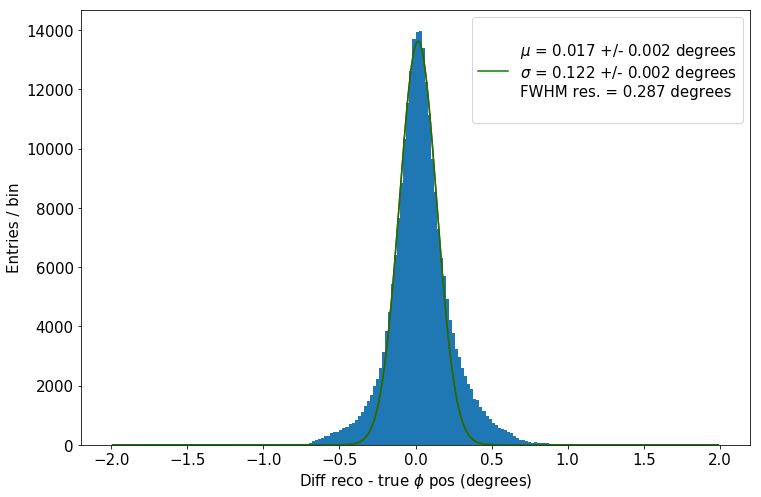

In [90]:
y, x, _ = hist(diff_phi_thr3*180/np.pi, bins=bins, range=(-2,2), new_figure=False)
plt.xlabel('Diff reco - true $\phi$ pos (degrees)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-0.2, 0.2))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} rad, {} degree'.format(f.values[1], f.values[1]))
print('FWHM = {} rad, {} degree'.format(f.values[2]*2.35, f.values[2] * 2.35))

legend = gtext_angle(f.values[1:],f.errors[1:])
xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)

### FWHM in arc
factor = 180/np.pi
print('In mm')
print(np.sin(f.values[2]/factor)*100*2.35)
print(np.sin(f.values[2]/factor)*130*2.35)

#### 6 mm pitch

[  4.83131605e+03   3.65667786e-02   1.93800643e-01]
[  4.80602040e+01   1.44122066e-03   2.39449772e-03]
Mean = 0.03656677857807422 rad, 0.03656677857807422 degree
FWHM = 0.4554315108717923 rad, 0.4554315108717923 degree
In mm
0.794876422502
1.03333934925


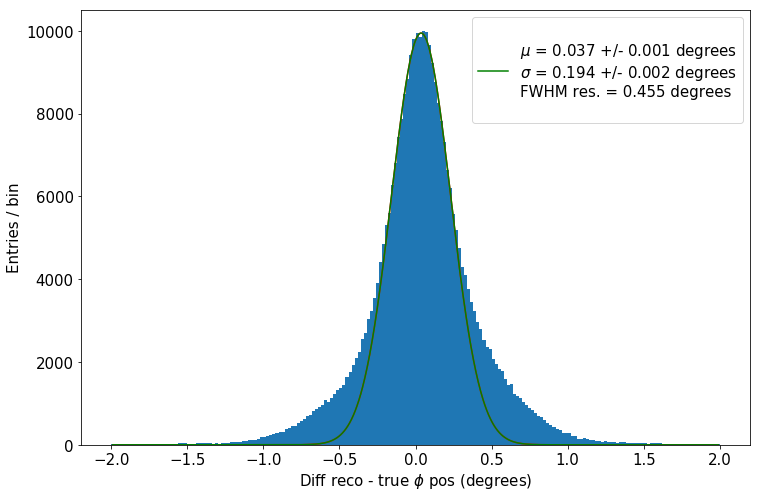

In [91]:
y, x, _ = hist(diff_phi_thr3_6mm*180/np.pi, bins=bins, range=(-2,2), new_figure=False)
plt.xlabel('Diff reco - true $\phi$ pos (degrees)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-0.2, 0.2))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} rad, {} degree'.format(f.values[1], f.values[1]))
print('FWHM = {} rad, {} degree'.format(f.values[2]*2.35, f.values[2] * 2.35))

legend = gtext_angle(f.values[1:],f.errors[1:])
xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)
factor = 180/np.pi
print('In mm')
print(np.sin(f.values[2]/factor)*100*2.35)
print(np.sin(f.values[2]/factor)*130*2.35)

#### 6 mm pitch - 10 rows only

[  2.54104900e+03   3.89171399e-02   1.97991812e-01]
[  2.86140762e+01   1.64598325e-03   2.74722753e-03]
Mean = 0.03891713993212442 rad, 0.03891713993212442 degree
FWHM = 0.4652807581295428 rad, 0.4652807581295428 degree
In mm
0.812066501372
1.05568645178


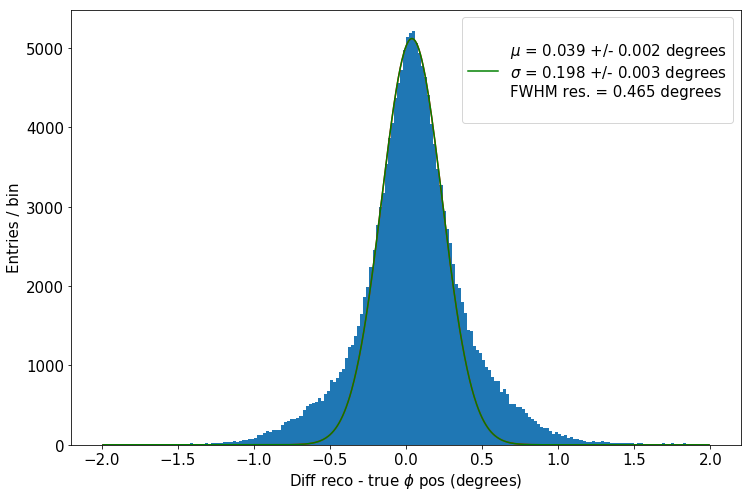

In [92]:
y, x, _ = hist(diff_phi_thr3_6mm_10rows*180/np.pi, bins=bins, range=(-2,2), new_figure=False)
plt.xlabel('Diff reco - true $\phi$ pos (degrees)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-0.2, 0.2))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} rad, {} degree'.format(f.values[1], f.values[1]))
print('FWHM = {} rad, {} degree'.format(f.values[2]*2.35, f.values[2] * 2.35))

legend = gtext_angle(f.values[1:],f.errors[1:])
xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)
factor = 180/np.pi
print('In mm')
print(np.sin(f.values[2]/factor)*100*2.35)
print(np.sin(f.values[2]/factor)*130*2.35)

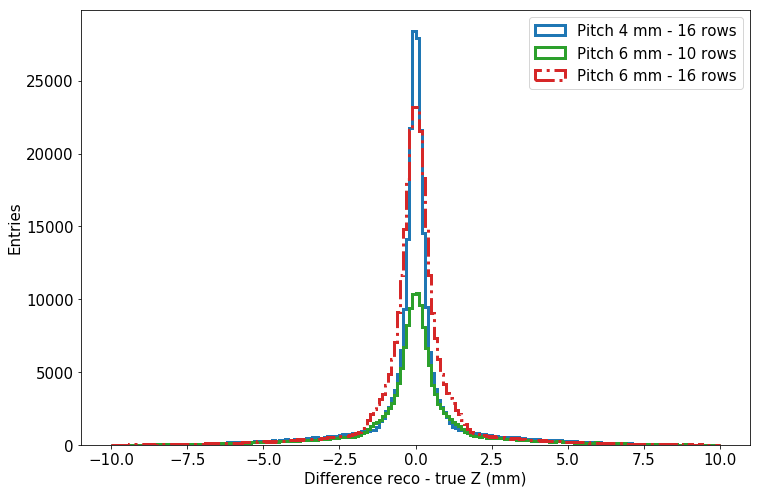

In [84]:
### Threshold 3 pes, pitch 4 mm

valid1 = reco_z1_thr3 < 1.e9
valid2 = reco_z2_thr3 < 1.e9
diff_z1_thr3 = reco_z1_thr3[valid1] - true_z1_thr3[valid1]
diff_z2_thr3 = reco_z2_thr3[valid2] - true_z2_thr3[valid2]
diff_z_thr3 = np.concatenate((diff_z1_thr3, diff_z2_thr3))

### Threshold 3 pes, pitch 6 mm

valid1 = reco_z1_thr3_6mm < 1.e9
valid2 = reco_z2_thr3_6mm < 1.e9
diff_z1_thr3_6mm = reco_z1_thr3_6mm[valid1] - true_z1_thr3_6mm[valid1]
diff_z2_thr3_6mm = reco_z2_thr3_6mm[valid2] - true_z2_thr3_6mm[valid2]
diff_z_thr3_6mm = np.concatenate((diff_z1_thr3_6mm, diff_z2_thr3_6mm))

valid1 = reco_z1_thr3_6mm_10rows < 1.e9
valid2 = reco_z2_thr3_6mm_10rows < 1.e9
diff_z1_thr3_6mm_10rows = reco_z1_thr3_6mm_10rows[valid1] - true_z1_thr3_6mm_10rows[valid1]
diff_z2_thr3_6mm_10rows = reco_z2_thr3_6mm_10rows[valid2] - true_z2_thr3_6mm_10rows[valid2]
diff_z_thr3_6mm_10rows = np.concatenate((diff_z1_thr3_6mm_10rows, diff_z2_thr3_6mm_10rows))

plot_range = (-10, 10)
bins = 200

h0 = plt.hist(diff_z_thr3, bins=bins, color=colors[0], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Pitch 4 mm - 16 rows', linewidth=3.0, linestyle=linestyle[0])
h2 = plt.hist(diff_z_thr3_6mm_10rows, bins=bins, color=colors[1], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Pitch 6 mm - 10 rows', linewidth=3.0, linestyle=linestyle[0])
h3 = plt.hist(diff_z_thr3_6mm, bins=bins, color=colors[2], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Pitch 6 mm - 16 rows', linewidth=3.0, linestyle=linestyle[1])
plt.xlabel('Difference reco - true Z (mm)')
plt.ylabel('Entries')
plt.legend(loc=1)

#### 4 mm pitch

[  1.26137201e+04   5.78927410e-04   2.47249618e-01]
[  4.36917720e+02   9.82078141e-03   1.00213915e-02]
Mean = 0.0005789274095495593 mm
FWHM = 0.5810366019504953 mm


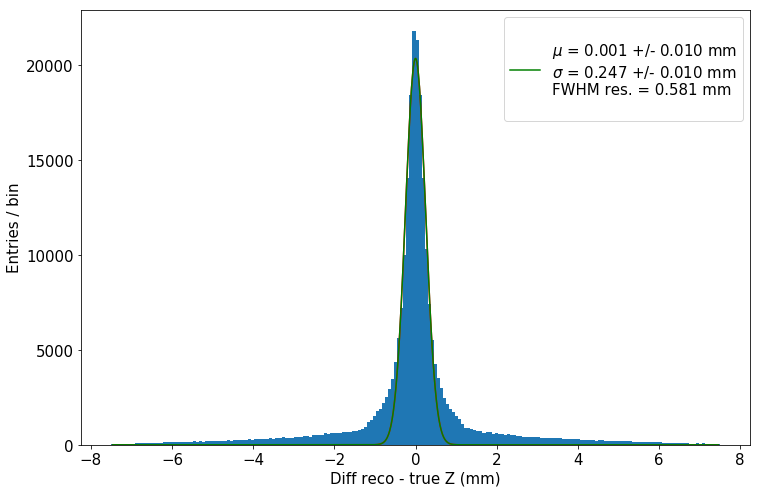

In [86]:
y, x, _ = hist(diff_z_thr3, bins=bins, range=(-7.5,7.5), new_figure=False)
plt.xlabel('Diff reco - true Z (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-0.6, 0.6))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))

legend = gtext(f.values[1:],f.errors[1:])

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)

#### 6 mm pitch

[  1.68257640e+04   2.61752257e-04   3.88014501e-01]
[  1.78026479e+02   4.16309783e-03   5.32775035e-03]
Mean = 0.0002617522567294656 mm
FWHM = 0.9118340764134547 mm


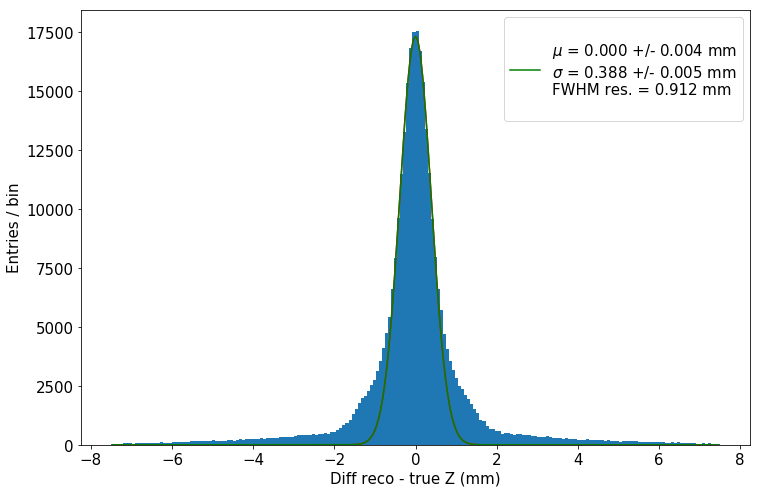

In [87]:
y, x, _ = hist(diff_z_thr3_6mm, bins=bins, range=(-7.5,7.5), new_figure=False)
plt.xlabel('Diff reco - true Z (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-0.6, 0.6))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))

legend = gtext(f.values[1:],f.errors[1:])

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)

#### 6 mm pitch - 10 rows

[  7.60734023e+03   1.37654558e-03   3.95647184e-01]
[  9.33785216e+01   4.86543086e-03   6.32430477e-03]
Mean = 0.001376545575579759 mm
FWHM = 0.9297708835302677 mm


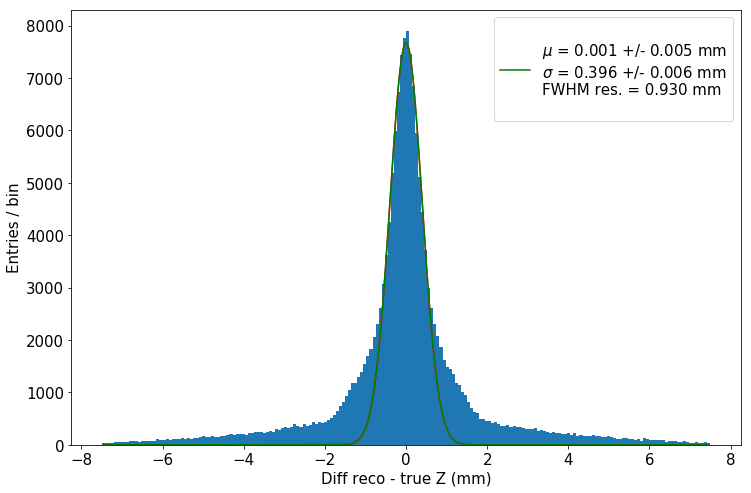

In [88]:
y, x, _ = hist(diff_z_thr3_6mm_10rows, bins=bins, range=(-7.5,7.5), new_figure=False)
plt.xlabel('Diff reco - true Z (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-0.6, 0.6))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))

legend = gtext(f.values[1:],f.errors[1:])

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)

In [37]:
np.where(reco_x1_thr1 - true_x1_thr1 ==0)

(array([     0,      1,      2, ..., 450384, 450385, 450386]),)

In [27]:
valid1 = reco_x1_thr2_6mm < 1.e9
valid2 = reco_x2_thr2_6mm < 1.e9
phi_true1 = np.arctan2(true_y1_thr2_6mm, true_x1_thr2_6mm) 
phi_reco1 = np.arctan2(reco_y1_thr2_6mm, reco_x1_thr2_6mm) 
phi_true2 = np.arctan2(true_y2_thr2_6mm, true_x2_thr2_6mm) 
phi_reco2 = np.arctan2(reco_y2_thr2_6mm, reco_x2_thr2_6mm) 

diff_phi1 = phi_reco1[valid1] - phi_true1[valid1]
diff_phi2 = phi_reco2[valid2] - phi_true2[valid2]
diff_phi = np.concatenate((diff_phi1, diff_phi2))

np.where(diff_phi1 < -3.)

(array([   206,    331,    365, ..., 159950, 159966, 159969]),)

In [29]:
valid1 = reco_x1_thr3 < 1.e9
valid2 = reco_x2_thr3 < 1.e9

rad_true1_thr3 = np.sqrt(true_x1_thr3 * true_x1_thr3 + true_y1_thr3 * true_y1_thr3) 
rad_reco1_thr3 = np.sqrt(reco_x1_thr3 * reco_x1_thr3 + reco_y1_thr3 * reco_y1_thr3)
rad_true2_thr3 = np.sqrt(true_x2_thr3 * true_x2_thr3 + true_y2_thr3 * true_y2_thr3) 
rad_reco2_thr3 = np.sqrt(reco_x2_thr3 * reco_x2_thr3 + reco_y2_thr3 * reco_y2_thr3)

diff_rad1_thr3 = rad_reco1_thr3[valid1] - rad_true1_thr3[valid1]
diff_rad2_thr3 = rad_reco2_thr3[valid2] - rad_true2_thr3[valid2]
diff_rad_thr3 = np.concatenate((diff_rad1_thr3, diff_rad2_thr3))

diff_rad1_thr3 = np.array(diff_rad1_thr3)
np.where(3.2 < diff_rad1_thr3 < 3.5)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [32]:
minor = diff_rad1_thr3 < 3.5

In [33]:
major = diff_rad1_thr3 > 3.2

In [34]:
minor & major

array([False, False, False, ..., False, False, False], dtype=bool)

In [36]:
ev_sel = events_thr3[valid1]

In [37]:
ev_sel[minor & major]

array([  2.44200000e+03,   5.21900000e+03,   2.43410000e+04,
         2.53510000e+04,   3.05070000e+04,   4.14410000e+04,
         5.36200000e+04,   6.00510000e+04,   6.01930000e+04,
         6.15870000e+04,   6.17340000e+04,   6.45330000e+04,
         8.06250000e+04,   8.21130000e+04,   1.01932000e+05,
         1.05600000e+05,   1.06289000e+05,   1.11006000e+05,
         1.11008000e+05,   1.12082000e+05,   1.13664000e+05,
         1.15749000e+05,   1.50678000e+05,   1.51144000e+05,
         1.52760000e+05,   1.65181000e+05,   1.70780000e+05,
         1.76281000e+05,   1.80592000e+05,   1.82013000e+05,
         1.84916000e+05,   1.91375000e+05,   1.95939000e+05,
         2.13076000e+05,   2.14527000e+05,   2.14985000e+05,
         2.15380000e+05,   2.22900000e+05,   2.31944000e+05,
         2.34586000e+05,   2.44327000e+05,   2.51288000e+05,
         2.52581000e+05,   2.60529000e+05,   2.81944000e+05,
         2.84586000e+05,   2.91670000e+05,   2.92972000e+05,
         2.94761000e+05,

In [42]:
rad_true1_thr3[valid1][minor & major][0]

100.25415841964913

In [43]:
rad_reco1_thr3[valid1][minor & major][0]

103.72375488281251

In [41]:
diff_rad1_thr3[0]

-0.325008539858473